Download dataset


In [ ]:
# !pip install -U -q kaggle
# !pip install  --quiet --upgrade tensorflow-federated-nightly nest-asyncio
# !mkdir -p ~/.kaggle
# !echo '{"username":"zhihaoliang","key":"37c44f583a070043285e729aa9e9ab09"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
 
# !kaggle datasets download -d paultimothymooney/breast-histopathology-images
# !mkdir data
# !unzip -q breast-histopathology-images.zip -d ./data

Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gc

2021-10-03 02:03:38.008053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-03 02:03:38.008084: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Print data size and last ten images in the dataset

In [ ]:
from glob import glob
image_pixel=50
images_num=15000
data = glob('./data/**/**/*.png', recursive=True)
print(len(data))
data[-10:]


1942668


['./data/14321/0/14321_idx5_x501_y201_class0.png',
 './data/14321/0/14321_idx5_x401_y501_class0.png',
 './data/14321/0/14321_idx5_x1151_y801_class0.png',
 './data/14321/0/14321_idx5_x351_y401_class0.png',
 './data/14321/0/14321_idx5_x1151_y651_class0.png',
 './data/14321/0/14321_idx5_x1051_y201_class0.png',
 './data/14321/0/14321_idx5_x1601_y451_class0.png',
 './data/14321/0/14321_idx5_x151_y251_class0.png',
 './data/14321/0/14321_idx5_x1451_y351_class0.png',
 './data/14321/0/14321_idx5_x501_y1051_class0.png']

Show one sample image

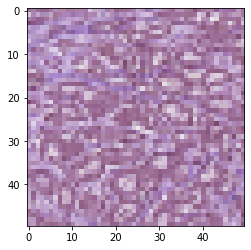

In [ ]:
import cv2
import matplotlib.pyplot as plt


for i in data[:1]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(image_pixel,image_pixel))
    plt.imshow(img_1,cmap='binary')
    plt.show()

Build train dataset and test dataset from tfrecord data

In [ ]:
def encoder(filenames, labels, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in zip(filenames, labels):
            image = open(filename, 'rb').read()

            feature = {
                # build feature dict       
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }

            # create example through dict
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

### select images and balance label percentage between IDC (+) and IDC (-)
### Select images for training and testing and balance labels distribution

In [ ]:
from collections import Counter
labels=[]
x_filenames=[]
one_size=0.5
one_num=int(images_num*one_size) 
zero_num=int(images_num*(1-one_size)) 

one_count=0
zero_count=0
for i in data:
    if i.endswith('.png'):
        label=int(i[-5])
        if images_num == len(labels):
            break
        if label==1 and one_count==one_num:
            continue
        if label==0 and zero_count==zero_num:
            continue
        if label == 1:
            one_count+=1
        if label == 0:
            zero_count+=1
        x_filenames.append(i)
        labels.append(label)

!mkdir tfrecord
train_tfrecord_file='./tfrecord/train.tfrecords'
test_tfrecord_file='./tfrecord/test.tfrecords'

train_images_filename,test_images_filename,train_labels_filename,test_labels_filename= \
train_test_split(x_filenames,labels,random_state=0,test_size=0.3)
print(Counter(labels))

mkdir: cannot create directory ‘tfrecord’: File exists
Counter({1: 7500, 0: 7500})


### Build tfrecord data and load dataset from tfrecord data. 
#### using tfrecord can load more images when ram is limited.

We tried to develop a new way to load more images using tfrecord, so we updated previous code (initial deep model and federated learning) as well into this way.

In [ ]:
def decoder(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    feature_discription = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_example(example_string): # decode each example
        feature_dic = tf.io.parse_single_example(example_string, feature_discription)
        feature_dic['image'] = tf.io.decode_png(feature_dic['image'])
        feature_dic['image'] = tf.image.resize(feature_dic['image'], [image_pixel, image_pixel])/255
        return feature_dic['image'], feature_dic['label']

    dataset = dataset.map(_parse_example)
    return dataset

encoder(train_images_filename,train_labels_filename,train_tfrecord_file)
encoder(test_images_filename,test_labels_filename,test_tfrecord_file)
train_data= decoder(train_tfrecord_file)
test_data = decoder(test_tfrecord_file)


train_images, train_labels = tuple(zip(*train_data))
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images,test_labels= tuple(zip(*test_data))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

2021-10-03 02:03:47.446390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-03 02:03:47.446528: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-03 02:03:47.446648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu20): /proc/driver/nvidia/version does not exist
2021-10-03 02:03:47.447096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Federate learning set up and client data prepare-up

In [ ]:
import tensorflow_federated as tff
import collections
import nest_asyncio
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_privacy as tfp
nest_asyncio.apply()
print(tff.__version__)

0.19.0


In [ ]:
NUM_CLIENTS = 600
NUM_EPOCHS = 1
BATCH_SIZE = 16
SHUFFLE_BUFFER = 209

print train size and test size of dataset

In [ ]:
def get_client_data_from_dataset(images,labels,client_num):
  image_count = len(images)
  print(image_count)
  image_per_client = int(np.floor(image_count/client_num))
  dataset = dict()
  for i in range(1, client_num+1):
      client_name = "client_" + str(i)
      start = image_per_client * (i-1)
      end = image_per_client * i
      dataset[client_name]  = dict((('pixels', images[start:end]),('label', labels[start:end])))
  return tff.simulation.datasets.TestClientData(dataset)

train_client_data=get_client_data_from_dataset(train_images,train_labels,NUM_CLIENTS)
test_client_data=get_client_data_from_dataset(test_images,test_labels,NUM_CLIENTS)

10500
4500


In [ ]:
print(train_images.shape)
print(test_images.shape)


(10500, 50, 50, 3)
(4500, 50, 50, 3)


Data preprocessing and put them into buffer (for client )

In [ ]:
def preprocess(dataset):
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=element['pixels'], y=element['label'])
  return dataset.map(batch_format_fn).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE)

Define ferderate learning model

In [ ]:
from tensorflow.keras import datasets, layers, models

example_dataset = train_client_data.create_tf_dataset_for_client(train_client_data.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)


def model_fn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_pixel, image_pixel,3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    return tff.learning.from_keras_model(
      model,
    input_spec=preprocessed_example_dataset.element_spec ,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


Define prepate client data method and select client method

In [ ]:
def get_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]
def select_random_clients(client_data,count):
   return np.random.choice(
    client_data.client_ids,
    size=count,
    replace=False)

Define training method

preprocess_test_dataset is to preprocess test dataset for testing.

In [ ]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=5)
total_clients = len(train_client_data.client_ids)



In [ ]:
def preprocess_test_dataset(dataset):
  def element_fn(element):
    return collections.OrderedDict(
        x=element['pixels'], y=element['label'])
  return dataset.map(element_fn).batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
processed_test_dataset = preprocess_test_dataset(
    test_client_data.create_tf_dataset_from_all_clients())

### To protect privacy, we select clients randomly using Poisson subsampling.
After that, we would like to know the model's performances when applying different noises(0, 0.5, 1.0, 2.0, 4.0)

In [ ]:
def train(rounds, noise_multiplier, clients_per_round, data_frame):

  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  sampling_prob = clients_per_round / total_clients

  learning_process = tff.learning.build_federated_averaging_process(
        model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
        model_update_aggregation_factory=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(model_fn)


  # Training loop.
  # acc=[]
  state = learning_process.initialize()
  for round_num in range(rounds):

    def select_random_clients_by_poisson_subsampling(client_data,sampling_prob):
      count= len(client_data.client_ids)
      x = np.random.uniform(size=count)
      return [ client_data.client_ids[i] for i in range(count)
        if x[i] < sampling_prob]

    sampled_clients=select_random_clients_by_poisson_subsampling(train_client_data,sampling_prob)
    sampled_train_data = get_federated_data(train_client_data,sampled_clients)


    state, metrics = learning_process.next(state, sampled_train_data)
    if(round_num % 10 == 0 ):
      metrics = eval_process(state.model, [processed_test_dataset])['eval']
      print(f'Round {round_num:3d}: {metrics} time: {round((time.time()-start_time)/(round_num+1.))} secs')
      data_frame = data_frame.append({'Round': round_num,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)
# print last round
  metrics = eval_process(state.model, [processed_test_dataset])['eval']
  print(f'Round {round_num:3d}: {metrics} time: {round((time.time()-start_time)/(round_num+1.))} secs')
  data_frame = data_frame.append({'Round': round_num,
                                'NoiseMultiplier': noise_multiplier,
                                **metrics}, ignore_index=True)
  # data_frame[noise_multiplier]=acc

  return data_frame


# Test model's noise tolerance and select a base noise multiplier

###### Train without applying noise
The final accuracy is around 83%.

In [ ]:
data_frame = pd.DataFrame()
NUM_ROUNDS = 100
import seaborn as sns
CLIENTS_PER_ROUND= 50

# when noise is zero 
noise_multiplier=.0
print(f'Starting training with noise multiplier: {noise_multiplier}')
start_time = time.time()
data_frame = train(NUM_ROUNDS, noise_multiplier, CLIENTS_PER_ROUND, data_frame)


Starting training with noise multiplier: 0.0
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.6922072)]) time: 83 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.64238095), ('loss', 0.68021715)]) time: 28 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.81714284), ('loss', 0.5715853)]) time: 27 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.82214284), ('loss', 0.49808267)]) time: 27 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.80404764), ('loss', 0.5069398)]) time: 24 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.73714286), ('loss', 0.55857766)]) time: 23 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.72761905), ('loss', 0.57716155)]) time: 23 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.8276191), ('loss', 0.4773532)]) time: 22 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.7942857), ('loss', 0.5114657)]) time: 21 secs
Round  90: OrderedDict([('sparse_categorical_accuracy

###### Train with applying noise 0.5
The final accuracy is around 79%. The noise starts to affect the result.

In [ ]:
noise_multiplier=.5

print(f'Starting training with noise multiplier: {noise_multiplier}')
start_time = time.time()
data_frame = train(NUM_ROUNDS, noise_multiplier, CLIENTS_PER_ROUND, data_frame)

Starting training with noise multiplier: 0.5
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.48809522), ('loss', 0.69323)]) time: 65 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.5157143), ('loss', 0.68661636)]) time: 24 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5102381), ('loss', 0.6792176)]) time: 22 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.7747619), ('loss', 0.6644579)]) time: 22 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.7442857), ('loss', 0.64554894)]) time: 20 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7435714), ('loss', 0.62760794)]) time: 20 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.7790476), ('loss', 0.60329)]) time: 20 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.7845238), ('loss', 0.5778595)]) time: 19 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.78738093), ('loss', 0.55633324)]) time: 19 secs
Round  90: Ordere

###### Train with applying noise 1.0
The final accuracy is around 78%.

In [ ]:
noise_multiplier=1.0

print(f'Starting training with noise multiplier: {noise_multiplier}')
start_time = time.time()
data_frame = train(NUM_ROUNDS, noise_multiplier, CLIENTS_PER_ROUND, data_frame)

Starting training with noise multiplier: 1.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.49785715), ('loss', 0.6948733)]) time: 57 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.50238097), ('loss', 0.6882847)]) time: 24 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.50857145), ('loss', 0.68465215)]) time: 21 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.61833334), ('loss', 0.6798379)]) time: 20 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.72309524), ('loss', 0.67305404)]) time: 19 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.75333333), ('loss', 0.66243684)]) time: 18 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.7561905), ('loss', 0.64720887)]) time: 19 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.7676191), ('loss', 0.6289963)]) time: 19 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.76619047), ('loss', 0.6113859)]) time: 19 secs
Round  9

###### Train with applying noise 2.0
The final accuracy is around 83%.

In [ ]:
noise_multiplier=2.0

print(f'Starting training with noise multiplier: {noise_multiplier}')
start_time = time.time()
data_frame = train(NUM_ROUNDS, noise_multiplier, CLIENTS_PER_ROUND, data_frame)

Starting training with noise multiplier: 2.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.49095237), ('loss', 0.6939846)]) time: 69 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.5057143), ('loss', 0.6898363)]) time: 22 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.50285715), ('loss', 0.687038)]) time: 21 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.50809526), ('loss', 0.6847462)]) time: 21 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.557381), ('loss', 0.681051)]) time: 19 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.68833333), ('loss', 0.6777192)]) time: 20 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.6945238), ('loss', 0.67396516)]) time: 20 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.75333333), ('loss', 0.6690146)]) time: 20 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.78119045), ('loss', 0.6645852)]) time: 19 secs
Round  90: Orde

###### Train with applying noise 4.0
The final accuracy is around 50% which is a very bad result.

In [ ]:
noise_multiplier=4.0

print(f'Starting training with noise multiplier: {noise_multiplier}')
start_time = time.time()
data_frame = train(NUM_ROUNDS, noise_multiplier, CLIENTS_PER_ROUND, data_frame)

Starting training with noise multiplier: 4.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.6906975)]) time: 62 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.6905717)]) time: 26 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.69020945)]) time: 24 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.502619), ('loss', 0.6904206)]) time: 23 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.51738095), ('loss', 0.6913494)]) time: 21 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.505), ('loss', 0.6908599)]) time: 21 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.50238097), ('loss', 0.6897492)]) time: 21 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.68902236)]) time: 20 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.688294)]) time: 20 secs
Round  90: Order

### Plot the result
We found that applying noise 2.0 can balance accuracy and privacy protection. 

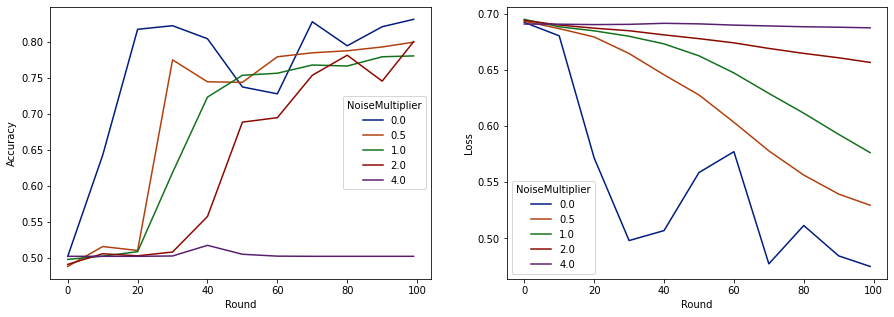

In [ ]:
import seaborn as sns


def make_plot(data_frame):
  plt.figure(figsize=(15, 5))
  dff = data_frame.rename(columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')
make_plot(data_frame)

#### Calculate how many expected clients per round we would need to get acceptable privacy with base noise 2.0.

In [ ]:
rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
              list(range(5, 64)) + [128, 256, 512])
print(rdp_orders)
total_clients = len(train_client_data.client_ids)


print(total_clients)
base_noise_multiplier = 2.0
base_clients_per_round = 50
target_delta = 1e-5
target_eps =2

def get_epsilon(clients_per_round):
  # If we use this number of clients per round and proportionally
  # scale up the noise multiplier, what epsilon do we achieve?
  q = clients_per_round / total_clients
  noise_multiplier = base_noise_multiplier
  noise_multiplier *= clients_per_round / base_clients_per_round
  rdp = tfp.compute_rdp(
      q, noise_multiplier=noise_multiplier, steps=NUM_ROUNDS, orders=rdp_orders)
  eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
  return clients_per_round, eps, noise_multiplier

def find_needed_clients_per_round():
  hi = get_epsilon(base_clients_per_round)
  if hi[1] < target_eps:
    return hi

  # Grow interval exponentially until target_eps is exceeded.
  while True:
    lo = hi
    hi = get_epsilon(2 * lo[0])
    if hi[1] < target_eps:
      break

  # Binary search.
  while hi[0] - lo[0] > 1:
    mid = get_epsilon((lo[0] + hi[0]) // 2)
    if mid[1] > target_eps:
      lo = mid
    else:
      hi = mid

  return hi

clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

[1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 128, 256, 512]
600
To get (2, 1e-05)-DP, use 65 clients with noise multiplier 2.6.


### Train the final fedrated model with applying noise 2.0 and 65 clients per round.

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.50214285), ('loss', 0.6911881)]) time: 73 secs
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.56976193), ('loss', 0.68808067)]) time: 32 secs
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5890476), ('loss', 0.6848977)]) time: 29 secs
Round  30: OrderedDict([('sparse_categorical_accuracy', 0.68190473), ('loss', 0.68067116)]) time: 27 secs
Round  40: OrderedDict([('sparse_categorical_accuracy', 0.71190476), ('loss', 0.6734164)]) time: 25 secs
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.775), ('loss', 0.6650572)]) time: 26 secs
Round  60: OrderedDict([('sparse_categorical_accuracy', 0.7764286), ('loss', 0.65634733)]) time: 25 secs
Round  70: OrderedDict([('sparse_categorical_accuracy', 0.78380954), ('loss', 0.6481058)]) time: 24 secs
Round  80: OrderedDict([('sparse_categorical_accuracy', 0.7816667), ('loss', 0.6403642)]) time: 24 secs
Round  90: OrderedDict([('sparse_categorical_accuracy', 0.78

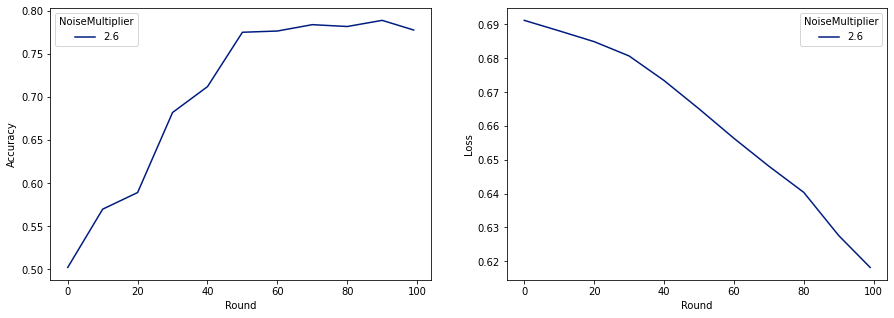

In [ ]:
rounds = 100
noise_multiplier = 2.6
clients_per_round = 65
start_time = time.time()
data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)


In [ ]:
make_plot(data_frame)
